In [1]:
from PIL import Image
import pandas as pd
import numpy as np
import cv2
import os
import sys
import time
from matplotlib.pyplot import imshow as ims
import matplotlib
import pytesseract 
import pylab as pl
import math

import box_to_order
import improve_img
import get_text

#instalar imutils
from imutils.object_detection import non_max_suppression

In [4]:
#Siguientes pasos:
# Lo primero es arreglar lo del orden, pedir a Noelia ayuda.
# Definir que voy a hacer con las frases que consiga - Audio, texto y traducción y a pdf(quiza)
# Hacer la interfaz visual donde meter las fotos y que haga lo que le comentes.
# A partir de ahi ya mejorar el reconocimiento de texto a muerte



In [5]:
def preparar_imagen(imagen,alto, ancho):#cogemos imagen
    image = cv2.imread(imagen)
    #hacemos copia
    orig = image.copy()
    
    #orig = tratar_imagen(orig)
    #orig = tratar_img_2(orig)

    #orig = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
    #sacamos alto y ancho
    (H, W) = image.shape[:2]
    #ponemos el nuevo alto y ancho, ¿PORQUE? Para hacerlo multiplo de 32, que se ajuste por tipo de pixel
    (newW, newH) = (alto, ancho)
    rW = W / float(newW)
    rH = H / float(newH)
    #lo aplicamos a la imagen y sacamos H y W de nuevo
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]
    
    return orig, image, rW, rH, H, W

In [6]:
#funcion para detectar las palabra y etiquetar los puntos
def detectar_palabras(image, H, W):
    #nombre de las etiquetas principales, REVISAR
    layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]
    #Importamos el detector de texto, REVISAR que es el EAST
    print("[INFO] loading EAST text detector...")
    #type=str
    
   
    
    net = cv2.dnn.readNet("frozen_east_text_detection.pb")
    #net = cv2.dnn.readNetFromDarknet(frozen_east_text_detection.pb)
    #Construimos el cuadrito que va a rodear la imagen
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),(123.68, 116.78, 103.94), swapRB=True, crop=False)
    start = time.time()
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    end = time.time()

    #Muestra info sobre cuanto ha tardado en detectarlo
    print("[INFO] text detection took {:.6f} seconds".format(end - start))

    #Construimos los planos para meter los cuadritos alrrededor de los textos
    #numRows te da el numero de palabras identificadas por sus
    (numRows, numCols) = scores.shape[2:4]
    
    
    return numRows, numCols, scores, geometry

In [7]:
def get_esquinas(numRows, numCols, scores, geometry):
    rects = []
    confidences = []
    for y in range(0, numRows):
        #Con los scores, probabilidad de que este bien, seguido de los
        #punto geometricos los ponemos en el texto para saber donde estan 

        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # loop sobre el numero de columnas
        for x in range(0, numCols):
            #metemos una variable de que si no hay suficiente confianza no lo meta, INVESTIGAR Y DECIDIR
            if scoresData[x] < 0.05: #args["min_confidence"]:
                continue

            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            # La imagen sera 4 veces mas pequeña?
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            #Extraer el angulo del texto para poder poner el recuadro girado
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height of
            # the bounding box

            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            """# compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box"""

            #Crear los puntos exactos donde se debe poner el recuadro
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)


            #Añadirlo a la lista de cuadros y de confianza
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
            
            
            
    return rects, confidences

In [186]:
def recortar_palabras(orig, rects, confidences, rW, rH, padding , H, W):

    #confThreshold = 0.4
    #nmsThreshold = 0.5
    boxes = non_max_suppression(np.array(rects), probs=confidences)
    #indices = cv2.dnn.NMSBoxesRotated(rects, confidences, confThreshold, nmsThreshold)
    palabras_separadas = []
    
    boxes = get_orden(boxes)

    
    # loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
        # scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)

        # in order to obtain a better OCR of the text we can potentially
        # apply a bit of padding surrounding the bounding box -- here we
        # are computing the deltas in both the x and y directions
        dX = int((endX - startX) * padding)
        dY = int((endY - startY) * padding)

        startX = max(0, startX - dX)
        startY = max(0, startY - dY)
        endX = min(W, endX + (dX * 2))
        endY = min(H, endY + (dY * 2))

    """
    # loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
            #Hacemos un reescalado del cuadrito identificador acorde al que hicimos al principio.
            startX = int(startX * rW)
            if int(startX - (startX * padding))  > 0:
                startX = int(startX - (startX * padding))
            startY = int(startY * rH)
            if int(startY - (startY * padding)) > 0:
                startY = int(startY - (startY * padding))
            endX = int(endX * rW)
            if int(endX + (endX * padding)) > 0:
                endX = int(endX + (endX * padding))
            endY = int(endY * rH)
            if int(endY + (endY * padding)) > 0:
                endY = int(endY + (endY * padding))

            #dX = int((endX - startX) * padding)
            #dY = int((endY - startY) * padding)

            #startX = max(0, startX - dX)
            #startY = max(0, startY - dY)
            #endX = min(W, endX + (dX * 2))
            #endY = min(H, endY + (dY * 2))
     """  
        #Dibujar el rectangulo alrededor del texto en la imagen.
        crop = orig[startY:endY,startX:endX]
        cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 3)
        palabras_separadas.append(crop)
        
        # extract the actual padded ROI
        roi = orig[startY:endY, startX:endX]

    #print('Sx:',startX)
    #print('Sy:',startY)
    #print('Ex:',endX)
    #print('Ey:',endY)
    #print('Has conseguido {} palabras'.format(len(palabras_separadas)))
    
    return palabras_separadas, orig, boxes
    # Mostrar la imagen ya con el texto detectado
    #cv2.imshow("Text Detection", orig)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()



IndentationError: unexpected indent (<ipython-input-186-b77c1afa3f0d>, line 58)

In [9]:
#Funcion para el OCR
def ocr(imagen):
    config = ("-l eng --oem 1 --psm 7")
    text = pytesseract.image_to_string(imagen, config=config)
    if text:
        print(text)
        return text
    else:
        print("No ha detectado nada")
    
    
#-l eng

In [ ]:
list = []
 if 

In [249]:
def prueba_1(nombre_imagen, size, resize = True, tratar = True, tratar_mas=True):
    orig, image, rW, rH, H, W = preparar_imagen(nombre_imagen,32*size,32*size) #Multiplicar 32 por algo para hacer su multiplo
    numRows, numCols, scores, geometry = detectar_palabras(image, H, W)
    rects, confidences = get_esquinas(numRows, numCols, scores, geometry)
    palabras, orig, boxes = recortar_palabras(orig, rects, confidences,rW, rH, 0.03 , H, W)
    imagenes_finales = []
    #return palabras
    palabras_text = []
    for i in range(len(palabras)):
        print(palabras[i].shape)
        if palabras[i] != []:
            if resize:
                imagen_resize = improve_img.resize_imagen(palabras[i],100)
            if tratar:
                imagen_tratada = improve_img.tratar_imagen(imagen_resize)
            if tratar_mas:
                imagen_final = improve_img.tratar_img_2(imagen_tratada)
            else:
                imagen_final = palabras[i]
    
            
        imagenes_finales.append(imagen_final) 
        ocrtext = get_text.ocr(imagenes_finales[i])
        palabras_text.append(ocrtext)
    return orig, imagenes_finales, palabras_text, 


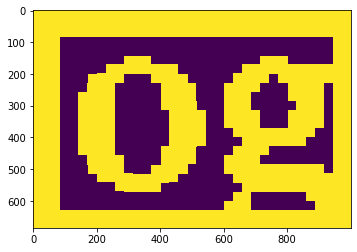

In [93]:
ims(imagenes_finales[7])

In [250]:
orig, imagenes_finales, palabras_text = prueba_1("tesseract-python/matr.jpg",20)

[INFO] loading EAST text detector...
[INFO] text detection took 0.307580 seconds
(68, 165, 3)
(65, 0, 3)


/home/josele639/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()
/home/josele639/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


ZeroDivisionError: division by zero

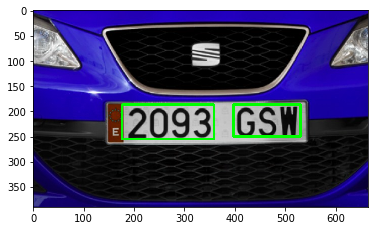

In [227]:
ims(orig)

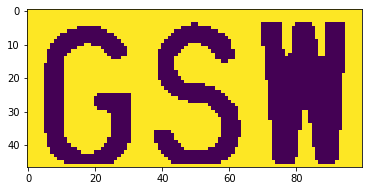

In [228]:
ims(imagenes_finales[1])

In [8]:
#Libreria leer foto, pruebas.
#imagen = cv2.imread("tesseract-python/piz1.jpeg")
#ocrtext1 = get_text.ocr(imagen)

'srlighed'

In [52]:
import goslate


In [54]:
#gs = goslate.Goslate()
#print(gs.translate('Hello word','es'))


In [12]:
Idiomas para traducir.
{u'gu': u'Gujarati', u'zh-TW': u'Chinese (Traditional)', u'ga': u'Irish', u'gl': u'Galician', u'la': u'Latin', u'lo': u'Lao', u'tr': u'Turkish', u'lv': u'Latvian', u'lt': u'Lithuanian', u'th': u'Thai', u'tg': u'Tajik', u'te': u'Telugu', u'ta': u'Tamil', u'yi': u'Yiddish', u'ceb': u'Cebuano', u'yo': u'Yoruba', u'de': u'German', u'da': u'Danish', u'el': u'Greek', u'eo': u'Esperanto', u'en': u'English', u'zh': u'Chinese', u'eu': u'Basque', u'et': u'Estonian', u'es': u'Spanish', u'ru': u'Russian', u'zh-CN': u'Chinese (Simplified)', u'ro': u'Romanian', u'be': u'Belarusian', u'bg': u'Bulgarian', u'ms': u'Malay', u'bn': u'Bengali', u'jw': u'Javanese', u'bs': u'Bosnian', u'ja': u'Japanese', u'ca': u'Catalan', u'cy': u'Welsh', u'cs': u'Czech', u'pt': u'Portuguese', u'tl': u'Filipino', u'pa': u'Punjabi', u'vi': u'Vietnamese', u'pl': u'Polish', u'hy': u'Armenian', u'hr': u'Croatian', u'ht': u'Haitian Creole', u'hu': u'Hungarian', u'hmn': u'Hmong', u'hi': u'Hindi', u'ha': u'Hausa', u'mg': u'Malagasy', u'uz': u'Uzbek', u'ml': u'Malayalam', u'mn': u'Mongolian', u'mi': u'Maori', u'mk': u'Macedonian', u'ur': u'Urdu', u'mt': u'Maltese', u'uk': u'Ukrainian', u'mr': u'Marathi', u'my': u'Myanmar (Burmese)', u'af': u'Afrikaans', u'sw': u'Swahili', u'is': u'Icelandic', u'it': u'Italian', u'iw': u'Hebrew', u'kn': u'Kannada', u'ar': u'Arabic', u'km': u'Khmer', u'zu': u'Zulu', u'az': u'Azerbaijani', u'id': u'Indonesian', u'ig': u'Igbo', u'nl': u'Dutch', u'no': u'Norwegian', u'ne': u'Nepali', u'ny': u'Chichewa', u'fr': u'French', u'fa': u'Persian', u'fi': u'Finnish', u'ka': u'Georgian', u'kk': u'Kazakh', u'sr': u'Serbian', u'sq': u'Albanian', u'ko': u'Korean', u'sv': u'Swedish', u'su': u'Sundanese', u'st': u'Sesotho', u'sk': u'Slovak', u'si': u'Sinhala', u'so': u'Somali', u'sl': u'Slovenian'}

SyntaxError: invalid syntax (<ipython-input-12-0bbd9beba1ac>, line 1)

In [13]:
def unificar_texto(palabras_text):
    palabra_unida = ' '.join(palabras_text)
    print(palabra_unida)
    return palabra_unida

In [229]:
frase = unificar_texto(palabras_text)

2093 GSH


In [15]:
from gtts import gTTS  
import os 
from pydub import AudioSegment
from pydub.playback import play
  

def get_audio(palabra_unida):
    mytext = palabra_unida
    myobj = gTTS(mytext, lang='es-us')    
    myobj.save("welcome.mp3")
    song = AudioSegment.from_mp3("welcome.mp3")
    play(song)


In [20]:
get_audio(frase)

NameError: name 'frase' is not defined

In [16]:
lista_cord = [[ 22 ,218, 197, 280], #5
 [201 ,212 ,298, 281], #6
 [ 56  ,38 ,149 ,106], #1
 [156 ,130 ,214 ,191], #4
 [103 ,138 ,143 ,192], #3
 [157  ,39 ,274 ,110]] #2

In [22]:
lista_cord = np.array(lista_cord)

In [17]:
##Porque no funciona si lo paso al visual

def get_orden(lista_cord):
    total_centro = []
    definicion={}
    count = 0
    #Creando los puntos centrales.
    lista_cord.tolist()
    
    for i in lista_cord:
        count += 1
        centro=[]
        A = int((i[0] + i[2])/2)
        centro.append(A)
        B = int((i[1] + i[3])/2)
        centro.append(B)
        centro.append(count)
        total_centro.append(centro)
       
    #Sacando los rangos. 
    total_rangos_y=[]
    for i in lista_cord:
        rango=[]
        A = abs(int((i[1] - i[3])/2))
    for c in total_centro:
        rangos_y = []
        B_1 = c[1] + A
        rangos_y.append(B_1)
        B_2 = c[1] - A
        rangos_y.append(B_2)
        rangos_y.append(c[0])
        rangos_y.append(c[2])
        total_rangos_y.append(rangos_y)
    
    
    #Creando los grupos de los rangos
    rangos_ordenados= sorted(total_rangos_y)
    gas = []
    for r_y in range(len(rangos_ordenados)):
        que_rango=[]
        que_rango.append(rangos_ordenados[r_y])
        for r_y2 in range(len(rangos_ordenados)):
            if rangos_ordenados[r_y][0] <= rangos_ordenados[r_y2][0]*1.1 and rangos_ordenados[r_y][1] >= rangos_ordenados[r_y2][1]*0.9:
                que_rango.append(r_y2)
        gas.append(que_rango)
        
    #Si solo con rangos no funciona.
    #for grupos in range(len(gas)):
        #for n_grupos in range(len(gas)):
            #if gas[grupos][2] == gas[n_grupos][2] and gas[grupos][2] == gas[n_grupos][2]:
                #print('Tikit')
                
    #Ordenando primero por la x y luego por la y, ya tenemos el orden correcto.
    from operator import itemgetter
    import operator 
    #gas = sorted(gas, key=operator.itemgetter(1, 2))
    gas.sort(key=lambda x: x[0][2])
    gas.sort(key=lambda x: x[1]) 

    
    #Crear una lista con las posiciones que deberian ser
    orden_final=[]
    cuenta = 0
    for orden in gas:
        l_cuenta=[]
        cuenta += 1
        l_cuenta.append(cuenta)
        l_cuenta.append(orden[0][3])
        orden_final.append(l_cuenta)
    
    #Meter toda la info en un dicc
    for num in range(len(total_centro)):
        definicion[num]='Centros:',total_centro[num],'Rangos y:', gas[num], 'Orden:',orden_final[num]
        orden_final[num]=orden_final[num]
    
    #Añadir a cada source su posicion concreta
    lista_cord_copy = lista_cord.tolist()
 
    for i in range(1,len(lista_cord)+1):
        for j in orden_final:          
                if i == j[1]:
                    lista_cord_copy[i-1].append(j[0])
                    #lista_cord_copy[3] = j[0]
                    pass
    
    
    #ordenando por posicion.
    lista_cord_copy.sort(key=lambda x: x[4])
    
    for i in range(len(lista_cord_copy)):
          lista_cord_copy[i].pop(4)
    
    
    lista_cord_copy = abs(np.array(lista_cord_copy))
    return lista_cord_copy
            


In [24]:
gasgas = np.array(gasgas)
total_centro = get_orden(gasgas)
total_centro 

NameError: name 'gasgas' is not defined

In [25]:
total_centro

NameError: name 'total_centro' is not defined

In [26]:
from operator import itemgetter
total_centro.sort(key=itemgetter(0))

NameError: name 'total_centro' is not defined

In [27]:
#Cemtro +- altura/2 = rango
Orde

NameError: name 'Orde' is not defined

In [28]:
total_centro

NameError: name 'total_centro' is not defined

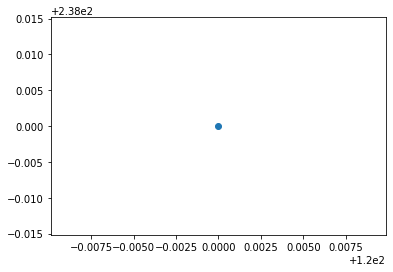

In [20]:
pl.scatter(total_centro[0][0],total_centro[0][1])

#Con el centro calculado lo siguiente seria buscar un patron que sea capaz de poner en su lugar cada palabra

In [19]:
cv2.imshow("gas",partes_imagen[5])
cv2.waitKey(0)

NameError: name 'partes_imagen' is not defined

In [188]:
#gray = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

In [18]:
#gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)


In [200]:
#Para pasar a blanco y negro
#(thresh, blackAndWhiteImage) = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

In [202]:
#tratado2 = cv2.medianBlur(blackAndWhiteImage, 3)

In [158]:
#Conclusiones a tener en cuenta

# - Cuanto mas se afina el resize mejor funciona al reconocedor de texto.